<a href="https://colab.research.google.com/github/Eparcham/Spark_Clustring/blob/master/EbrahimParcham_firsthomework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install spark

In [ ]:
!pip install pyspark
!pip install liac-arff

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 38 kB/s 
     |████████████████████████████████| 199 kB 39.6 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=a1e63a2df3098dffcce55d09a9f56c43da719548ea0408b2d0190c4cf1700642
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11732 sha256=3928eca55591aa4d76cbe6bd2e6ddc6f4cf9d881e0390307b8d0b5a47d22e2c2
  Stored in directory: /root/.cache/pip/wheels/1f/0f/15/332ca86cbebf25ddf98518caaf887945fbe1712b97a0f2493b
Successfully built liac-arff


## Import Lib

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import Normalizer
import pandas as pd
from scipy.io.arff import loadarff 
import numpy as np
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from datetime import datetime
import matplotlib.dates as md
sc = SparkContext('local')
spark = SparkSession(sc)

## load dataset and spilt to (train,test) and train with 3 cluster and Evaluator clustring with RMSSTD and report center and distnace 

In [ ]:
!wget https://raw.githubusercontent.com/deric/clustering-benchmark/master/src/main/resources/datasets/real-world/wine.arff

--2022-06-25 12:24:43--  https://raw.githubusercontent.com/deric/clustering-benchmark/master/src/main/resources/datasets/real-world/wine.arff
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14528 (14K) [text/plain]
Saving to: ‘wine.arff’

wine.arff           100%[===================>]  14.19K  --.-KB/s    in 0s      

2022-06-25 12:24:43 (61.0 MB/s) - ‘wine.arff’ saved [14528/14528]



In [ ]:
raw_data = loadarff('wine.arff')
df = pd.DataFrame(raw_data[0])
df.head()

,class,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280/OD315_of_diluted_wines,Proline
0,b'1',14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,b'1',13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,b'1',13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,b'1',14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,b'1',13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


# **MAKE SAFE MODE TO LIBSVM SPARK FORMAT**

In [ ]:

Data = df.to_numpy()

with open("temp.txt",'w') as f:
     for i in range(Data.shape[0]):
         txt = ""
         for j in range(Data.shape[1]):
            if j==0: # is for label
                d = Data[i][j].decode("utf-8")
                txt+= str(d)+ " "
            else:
                d = str(Data[i][j])
                txt+= str(j) + ":" + d + " "


         f.writelines(txt)
         f.writelines("\n")


# **LOAD DATA AND NORMALIZ**

In [ ]:
# Loads data.

dataset =  spark.read.format("libsvm").load("temp.txt")
normalizer = Normalizer(inputCol="features", outputCol="normFeatures", p=1.0)
l1NormData = normalizer.transform(dataset)
train, test = dataset.randomSplit(weights=[0.9,0.1], seed=200)


# **train and test**

In [ ]:
# Trains a k-means model.
kmeans = KMeans().setK(3).setSeed(1)
model = kmeans.fit(train)

# Make predictions
predictions = model.transform(train)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Train squared euclidean distance = " + str(silhouette))
print("===================================")
## test evaluator
# Make predictions
predictions_test = model.transform(test)
silhouette_test  = evaluator.evaluate(predictions_test)
print("Test squared euclidean distance = " + str(silhouette_test))

# Shows the result.
centers = model.clusterCenters()
print("===================================")
print("Cluster Centers: ")
for center in centers:
    print(center)

Train squared euclidean distance = 0.7318886250112395
Test squared euclidean distance = 0.7731550466845423
Cluster Centers: 
[1.25257143e+01 2.54365079e+00 2.29365079e+00 2.08142857e+01
 9.28730159e+01 2.08634921e+00 1.76714286e+00 3.87460317e-01
 1.46460317e+00 4.11079363e+00 9.42857143e-01 2.47539683e+00
 4.57222222e+02]
[1.37934884e+01 1.88883721e+00 2.42372093e+00 1.69581395e+01
 1.05395349e+02 2.86348837e+00 3.00441860e+00 2.89069767e-01
 1.87674419e+00 5.66674419e+00 1.07348837e+00 3.11488372e+00
 1.18202326e+03]
[1.29477966e+01 2.52237288e+00 2.41966102e+00 1.99101695e+01
 1.03694915e+02 2.09237288e+00 1.58203390e+00 3.93050847e-01
 1.51457627e+00 5.72762712e+00 8.74338983e-01 2.35169492e+00
 7.26796610e+02]


## plot data in matplotlib


In [ ]:
def plot_cluster(cluster, color, data_pd):
    data = data_pd[data_pd.label == cluster]
    dates = [x for x in data.features]
    for i in range(len(dates)):
        plt.scatter(dates[i][0],dates[i][1],color=color)

## matplot

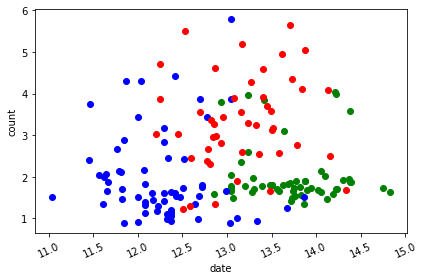

In [ ]:
import matplotlib.pyplot as plt
data_pd = train.toPandas()
ax = plt.gca()
plt.xticks(rotation=25)
clusters = [1, 2, 3]
colors = ["green", "blue", "red"]
for cluster, color in zip(clusters, colors):
    plot_cluster(cluster, color, data_pd)


plt.xlabel("date")
plt.ylabel("count")
plt.tight_layout()
plt.show()


## PLOTY PLOT

In [ ]:
import plotly.express as px
import pandas as pd

In [ ]:
from numpy.ma.core import append
data = data_pd[data_pd.label == 1]
dates = [x for x in data_pd.features]
df = pd.DataFrame(dict(
    x = [dates[i][0] for i in range(len(dates))],
    y = [dates[i][1] for i in range(len(dates))],
    label = ["class1" if i==1 else "class2" if i==2 else "class3"  for i in data_pd.label],
))
fig = px.scatter(df, x="x", y="y" ,color = "label")
fig.show()

In [ ]:
train.show(2)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  1.0|(13,[0,1,2,3,4,5,...|
|  1.0|(13,[0,1,2,3,4,5,...|
+-----+--------------------+
only showing top 2 rows



## Train again with diffrent num of cluster and evaluate data

In [ ]:
silhouette_score_train=[]
silhouette_score_test=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features', metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    
    KMeans_algo=KMeans(featuresCol='features', k=i)
    
    KMeans_fit=KMeans_algo.fit(train)
    
    output=KMeans_fit.transform(train)
    
    score=evaluator.evaluate(output)
    
    silhouette_score_train.append(score)

    output_test=KMeans_fit.transform(test)
    
    score_test=evaluator.evaluate(output_test)

    silhouette_score_test.append(score_test)
    
    print("Silhouette Score (RMSSTD) Train:",score," Silhouette Score (RMSSTD) Test",score_test)

Silhouette Score (RMSSTD) Train: 0.8193295862137379  Silhouette Score (RMSSTD) Test 0.8070475188166922
Silhouette Score (RMSSTD) Train: 0.726165960526605  Silhouette Score (RMSSTD) Test 0.5102110918340272
Silhouette Score (RMSSTD) Train: 0.7302698889022473  Silhouette Score (RMSSTD) Test 0.6245555117711683
Silhouette Score (RMSSTD) Train: 0.731396716079556  Silhouette Score (RMSSTD) Test 0.6020561326340114
Silhouette Score (RMSSTD) Train: 0.7218857935981309  Silhouette Score (RMSSTD) Test 0.3666006757705994
Silhouette Score (RMSSTD) Train: 0.7044837672686792  Silhouette Score (RMSSTD) Test 0.5070225907870137
Silhouette Score (RMSSTD) Train: 0.7317831307794558  Silhouette Score (RMSSTD) Test 0.4086236620399863
Silhouette Score (RMSSTD) Train: 0.6935643130133582  Silhouette Score (RMSSTD) Test 0.30014950581150357


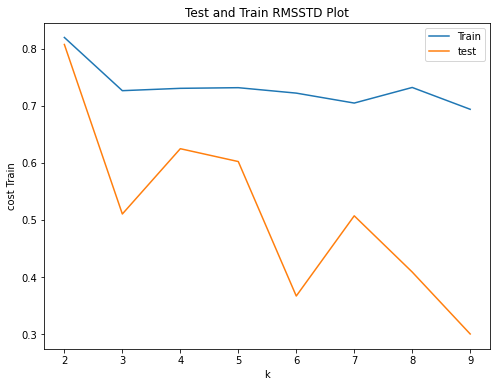

In [ ]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.set_title('Test and Train RMSSTD Plot')
ax.plot(range(2,10),silhouette_score_train)
ax.set_xlabel('k')
ax.set_ylabel('cost Train')

ax.plot(range(2,10),silhouette_score_test)
ax.set_xlabel('k')
ax.set_ylabel('cost Train')

ax.legend(['Train', 'test'])